In [16]:
from aux import *

In [3]:
dataset = np.loadtxt("covtype.data", delimiter=",")

In [4]:
print(dataset.shape)

(581012, 55)


In [9]:
train = dataset[:11340]
X_train = train[:, :-1]
y_train = train[:, -1]

In [12]:
val = dataset[11340:11340+3780]
X_val = val[:, :-1]
y_val = val[:, -1]

In [15]:
test = dataset[11340+3780:11340+3780+565892]
X_test = test[:, :-1]
y_test = test[:, -1]

In [45]:
data_preprocess = Pipeline(
    [
        ("PCA", PCA(0.95)),
        ("VT", VarianceThreshold(0.01)),
        ("Scaler", StandardScaler()),
    ]
)

Matriz de correlación pre y post procesado (dígitos)


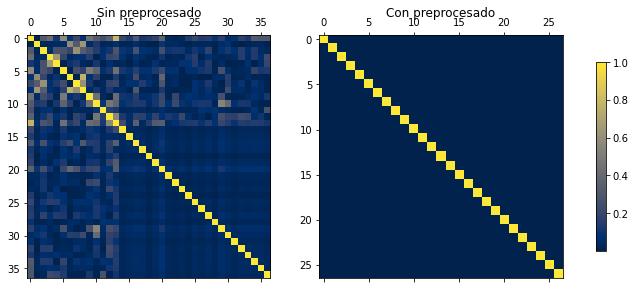

In [46]:
show_preprocess_correlation_matrix(X_train, data_preprocess)

In [47]:
X_train = data_preprocess.fit_transform(X_train, y_train)

In [48]:
seed = 6
models = []
models += [
    (
        "Logistic regresion: C={}".format(c),
        LogisticRegression(
            C=c, multi_class="ovr", penalty="l2", max_iter=1000, random_state=seed
        ),
    )
    for c in np.logspace(-2, 2, 3)
]
models += [
    (
        "RidgeClassifier: \u03B1={}".format(a),
        RidgeClassifier(alpha=a, random_state=seed, max_iter=1000),
    )
    for a in np.logspace(-2, 2, 3)
]
models += [
    (
        "Perceptron: \u03B1={}".format(a),
        Perceptron(alpha=a, penalty="l2", random_state=seed, max_iter=1000),
    )
    for a in np.logspace(-7, -3, 3)
]

# Devolvemos el mejor modelo de entre los considerados
best_model = kfold_models(models, X_train, y_train, seed, accuracy_score)

Los modelos que se van a considerar son: 
	 Logistic regresion: C=0.01
	 Logistic regresion: C=1.0
	 Logistic regresion: C=100.0
	 RidgeClassifier: α=0.01
	 RidgeClassifier: α=1.0
	 RidgeClassifier: α=100.0
	 Perceptron: α=1e-07
	 Perceptron: α=1e-05
	 Perceptron: α=0.001


--> Logistic regresion: C=0.01 <--
Score en K-fold: 0.605


--> Logistic regresion: C=1.0 <--
Score en K-fold: 0.640


--> Logistic regresion: C=100.0 <--
Score en K-fold: 0.643


--> RidgeClassifier: α=0.01 <--
Score en K-fold: 0.571


--> RidgeClassifier: α=1.0 <--
Score en K-fold: 0.571


--> RidgeClassifier: α=100.0 <--
Score en K-fold: 0.571


--> Perceptron: α=1e-07 <--
Score en K-fold: 0.519


--> Perceptron: α=1e-05 <--
Score en K-fold: 0.500


--> Perceptron: α=0.001 <--
Score en K-fold: 0.474



Mejor modelo: LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, 

In [49]:
# Entrenamos el mejor modelo en todo el conjunto de datos
best_model.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=6,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [50]:
X_test = data_preprocess.transform(X_test)

In [51]:
print("Accuracy en test: {:.3f}%".format(100 * best_model.score(X_test, y_test)))

Accuracy en test: 51.956%
